In [52]:
# Calcule et structure de données (dataframe)
import pandas as pd
import numpy as np

# Affichage de graphique
import matplotlib.pyplot as plt
import seaborn as sns

# Modèles et métriques
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping


In [3]:
data = pd.read_csv('trainTest_imputed_df_0608.csv')
controle = pd.read_csv('controle_imputed_df_0608.csv')

In [4]:
data

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Unit1,Unit2,SepsisLabel,SepsisLabel_Previous
0,9,27.92,1,-0.03,1,0,117.0,99.0,36.0,116.0,...,37.6,12.70,46.4,8.900000,124.000000,64.000000,0.0,1.0,0,0
1,9,27.92,1,-0.03,2,1,117.0,99.0,36.0,116.0,...,37.6,12.70,46.4,8.900000,124.000000,64.000000,0.0,1.0,0,0
2,9,27.92,1,-0.03,3,2,117.6,99.2,36.0,116.4,...,37.6,12.70,46.4,8.900000,124.000000,64.000000,0.0,1.0,0,0
3,9,27.92,1,-0.03,4,3,118.2,99.4,36.0,116.8,...,31.0,9.65,40.8,3.900000,180.000000,114.000000,0.0,1.0,0,0
4,9,27.92,1,-0.03,5,4,118.8,99.6,36.0,117.2,...,28.0,9.30,39.8,4.033333,190.666667,115.333333,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245935,119994,71.00,1,-29.57,38,37,76.0,98.0,37.6,126.0,...,30.3,10.20,57.0,11.400000,158.000000,62.000000,0.0,1.0,0,0
245936,119994,71.00,1,-29.57,39,38,76.0,98.0,37.5,124.0,...,30.3,10.20,57.0,11.400000,158.000000,62.000000,0.0,1.0,0,0
245937,119994,71.00,1,-29.57,40,39,76.0,96.0,37.5,130.5,...,30.3,10.20,57.0,11.400000,158.000000,62.000000,0.0,1.0,0,0
245938,119994,71.00,1,-29.57,41,40,74.0,98.0,37.5,122.0,...,30.3,10.20,57.0,11.400000,158.000000,62.000000,0.0,1.0,0,0


# Division des données en ensembles de formation et de test par patient

In [9]:
df = data.drop(columns=['SepsisLabel_Previous', 'Unit1', 'Unit2'])

In [5]:
from sklearn.model_selection import train_test_split

def split_train_test_df(full_df):  
    # Identifier les ID uniques des patients
    unique_patients = full_df['Patient_ID'].unique()

    # Séparer les ID des patients en ensembles d'entraînement et de test
    train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

    # Créer les ensembles d'entraînement et de test en utilisant les ID des patients
    train_df = full_df[full_df['Patient_ID'].isin(train_patients)]
    test_df = full_df[full_df['Patient_ID'].isin(test_patients)]
    
    return train_df, test_df
    

def split_train_test_df_v2(full_df, label='SepsisLabel'):
    """
    Divise un DataFrame en ensembles d'entraînement et de test en stratifiant par l'étiquette spécifiée,
    s'assurant ainsi que les données d'un même patient ne soient pas réparties entre les deux ensembles
    pour éviter la fuite d'informations et en préservant la proportion entre les classes.

    Parameters:
    - full_df (pandas.DataFrame): DataFrame complet contenant les données des patients.
    - label (str): Nom de la colonne étiquette utilisée pour la stratification.

    Returns:
    - X_train (pandas.DataFrame): Caractéristiques de l'ensemble d'entraînement.
    - y_train (pandas.Series): Étiquettes de l'ensemble d'entraînement.
    - X_test (pandas.DataFrame): Caractéristiques de l'ensemble de test.
    - y_test (pandas.Series): Étiquettes de l'ensemble de test.
    """
    # Identifier les ID uniques des patients
    unique_patients = full_df['Patient_ID'].unique()
    
    # Créer un DataFrame temporaire pour mapper chaque ID patient à son label
    patient_labels = full_df[[label, 'Patient_ID']].groupby('Patient_ID').max().reset_index()

    # Séparer les ID des patients en ensembles d'entraînement et de test avec stratification
    train_patients, test_patients = train_test_split(patient_labels['Patient_ID'], test_size=0.2, random_state=42, stratify=patient_labels[label])

    # Créer les ensembles d'entraînement et de test en utilisant les ID des patients
    train_df = full_df[full_df['Patient_ID'].isin(train_patients)]
    test_df = full_df[full_df['Patient_ID'].isin(test_patients)]
    
    
    return train_df, test_df


In [10]:
train_df, test_df = split_train_test_df_v2(df)

In [11]:
train_df

,Patient_ID,Age,Gender,HospAdmTime,ICULOS,Hour,HR,O2Sat,Temp,SBP,...,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SepsisLabel
0,9,27.92,1,-0.03,1,0,117.0,99.0,36.0,116.0,...,4.000000,1.5,23.2,37.600,12.700,46.4,8.900000,124.000000,64.000000,0
1,9,27.92,1,-0.03,2,1,117.0,99.0,36.0,116.0,...,4.000000,1.5,23.2,37.600,12.700,46.4,8.900000,124.000000,64.000000,0
2,9,27.92,1,-0.03,3,2,117.6,99.2,36.0,116.4,...,4.000000,1.5,23.2,37.600,12.700,46.4,8.900000,124.000000,64.000000,0
3,9,27.92,1,-0.03,4,3,118.2,99.4,36.0,116.8,...,3.600000,1.5,23.2,31.000,9.650,40.8,3.900000,180.000000,114.000000,0
4,9,27.92,1,-0.03,5,4,118.8,99.6,36.0,117.2,...,3.600000,1.5,23.2,28.000,9.300,39.8,4.033333,190.666667,115.333333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245893,119987,75.00,0,-28.15,35,34,61.0,100.0,37.6,142.0,...,4.018750,1.2,28.4,25.544,8.236,57.0,15.792000,158.000000,89.880000,0
245894,119987,75.00,0,-28.15,36,35,61.0,99.0,37.6,146.0,...,3.995833,1.2,28.4,25.496,8.224,57.0,15.928000,158.000000,89.920000,0
245895,119987,75.00,0,-28.15,37,36,60.0,100.0,37.6,145.0,...,3.972917,1.2,28.4,25.448,8.212,57.0,16.064000,158.000000,89.960000,0
245896,119987,75.00,0,-28.15,38,37,64.5,100.0,37.5,145.0,...,3.950000,1.2,28.4,25.400,8.200,57.0,16.200000,158.000000,90.000000,0


# Création des séquences de temps

In [27]:
# Fonction pour créer des séquences 
# def create_sequences(df, sequence_length):
#     sequences = []
#     labels = []
#     for patient_id in df['Patient_ID'].unique():
#         patient_data = df[df['Patient_ID'] == patient_id].drop(columns=['Patient_ID'])
#         for i in range(len(patient_data) - sequence_length):
#             sequence = patient_data.iloc[i:i + sequence_length].drop(columns=['SepsisLabel']).values
#             label = patient_data.iloc[i + sequence_length]['SepsisLabel']
#             sequences.append(sequence)
#             labels.append(label)
#     return np.array(sequences), np.array(labels)



def create_sequences_for_sepsis_prediction(df, sequence_length, hours_before=6):
    sequences = []
    labels = []
    # Convert hours to the number of steps in the dataset if the data is hourly
    steps_before = hours_before  # Assuming one row per hour; adjust if your data has different time steps

    for patient_id in df['Patient_ID'].unique():
        patient_data = df[df['Patient_ID'] == patient_id].sort_values('Hour').reset_index(drop=True)
        # Number of data points minus the sequence length and steps before to prevent index error
        for i in range(len(patient_data) - sequence_length - steps_before + 1):
            sequence = patient_data.iloc[i:i + sequence_length].drop(columns=['Patient_ID', 'SepsisLabel']).values
            # Check if sepsis occurs within the next 'steps_before' hours
            label = int(any(patient_data.iloc[i + sequence_length:i + sequence_length + steps_before]['SepsisLabel']))
            sequences.append(sequence)
            labels.append(label)
    return np.array(sequences), np.array(labels)

# def extract_sequences(df, id_col, time_col, feature_cols, label_col=None):
#     """
#     Extrait les séquences de données pour chaque identifiant unique dans un DataFrame.

#     Args:
#     df (pd.DataFrame): DataFrame contenant les données.
#     id_col (str): Nom de la colonne contenant les identifiants uniques pour chaque séquence.
#     time_col (str): Nom de la colonne contenant les marqueurs temporels pour ordonner les données.
#     feature_cols (list of str): Liste des noms des colonnes à inclure dans les séquences.
#     label_col (str, optional): Nom de la colonne contenant les étiquettes, si incluses dans les séquences.

#     Returns:
#     list of np.array: Liste de tableaux NumPy, chaque tableau représentant une séquence de données pour un identifiant.
#     """
#     unique_ids = df[id_col].unique()
#     sequences = []
    
#     for unique_id in unique_ids:
#         individual_data = df[df[id_col] == unique_id].sort_values(time_col)
#         if label_col:
#             sequence = individual_data[feature_cols + [label_col]]
#         else:
#             sequence = individual_data[feature_cols]
#         sequences.append(sequence.to_numpy())
    
#     return sequences

import numpy as np
import pandas as pd

def extract_sequences_and_labels(df, id_col, time_col, feature_cols, label_col, sequence_length, hours_before=6):
    """
    Extrait les séquences de données et les étiquettes correspondantes pour chaque identifiant unique,
    en décalant les étiquettes pour prédire l'apparition du sepsis 6 heures à l'avance.

    Args:
    df (pd.DataFrame): DataFrame contenant les données.
    id_col (str): Nom de la colonne contenant les identifiants uniques pour chaque séquence.
    time_col (str): Nom de la colonne contenant les marqueurs temporels pour ordonner les données.
    feature_cols (list of str): Liste des noms des colonnes à inclure dans les séquences.
    label_col (str): Nom de la colonne contenant les étiquettes.
    sequence_length (int): Nombre de points de données dans chaque séquence.
    hours_before (int): Nombre d'heures à prédire à l'avance (converti en nombre de pas si nécessaire).

    Returns:
    list of np.array: Liste de tableaux NumPy représentant les séquences de données.
    list of int: Liste des étiquettes correspondantes pour chaque séquence.
    """
    sequences = []
    labels = []
    unique_ids = df[id_col].unique()
    
    for unique_id in unique_ids:
        individual_data = df[df[id_col] == unique_id].sort_values(time_col)
        num_records = len(individual_data)
        for i in range(num_records - sequence_length - hours_before + 1):
            start_index = i
            end_index = i + sequence_length
            label_index = end_index + hours_before - 1

            # Ensure we do not go beyond the last available data point
            if label_index < num_records:
                sequence = individual_data.iloc[start_index:end_index][feature_cols].values
                label = individual_data.iloc[label_index][label_col]
                sequences.append(sequence)
                labels.append(label)
    
    return sequences, labels


def pad_with_last_observation(sequences, max_length):
    """
    Remplit chaque séquence jusqu'à une longueur maximale avec la dernière observation de la séquence.
    
    Args:
    sequences (list of np.array): Liste des séquences (arrays NumPy) à remplir.
    max_length (int): Longueur maximale des séquences après le padding.
    
    Returns:
    np.array: Array NumPy des séquences remplies.
    """
    # Initialisation du tableau résultant
    padded_sequences = np.zeros((len(sequences), max_length, sequences[0].shape[1]))

    # Boucle sur chaque séquence pour appliquer le padding
    for i, sequence in enumerate(sequences):
        length = sequence.shape[0]
        # Remplissage de la séquence avec ses propres données jusqu'à la fin
        padded_sequences[i, :length] = sequence
        # Si la séquence est plus courte que max_length, on utilise la dernière observation pour remplir
        if length < max_length:
            padded_sequences[i, length:] = sequence[-1]

    return padded_sequences


def get_feature_columns(df, exclude_cols):
    """
    Détermine les colonnes de caractéristiques pour un DataFrame en excluant certaines colonnes spécifiées.

    Args:
    df (pd.DataFrame): Le DataFrame à partir duquel extraire les noms des colonnes.
    exclude_cols (list of str): Liste des noms des colonnes à exclure des caractéristiques.

    Returns:
    list of str: Liste des noms des colonnes de caractéristiques.
    """
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    return feature_cols

In [12]:
# # Créer des séquences pour les ensembles d'entraînement et de test
# sequence_length = 6  # Longueur de la séquence
# X_train, y_train = create_sequences(train_df, sequence_length)
# X_test, y_test = create_sequences(test_df, sequence_length)

In [28]:
exclude_columns = ['Patient_ID', 'Hour', 'SepsisLabel']
feature_cols_train = get_feature_columns(train_df, exclude_columns)
feature_cols_test = get_feature_columns(test_df, exclude_columns)

sequences_train, labels_train = extract_sequences_and_labels(train_df, 'Patient_ID', 'Hour', feature_cols_train, 'SepsisLabel', 6, 6)
sequences_test, labels_test = extract_sequences_and_labels(test_df, 'Patient_ID', 'Hour', feature_cols_test, 'SepsisLabel', 6, 6)

max_length = max(len(seq) for seq in sequences)
padded_sequences_train = pad_with_last_observation(sequences_train, max_length)
padded_sequences_test = pad_with_last_observation(sequences_test, max_length)

In [30]:
# La taille de padded_sequences correspond : 
    # au nombre de patient, pour shape[0]
    # le nombre max de prise de mesures (max du nombre de lignes / patient)
padded_sequences_train.shape

(155318, 6, 38)

In [18]:
df['Patient_ID'].nunique()

4787

# Normalisation des données


In [31]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(sequences):
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Flatten sequences to fit the scaler then reshape back to the original sequence shape
    sequence_shape = sequences.shape
    sequences_flattened = sequences.reshape(-1, sequences.shape[2])
    sequences_normalized = scaler.fit_transform(sequences_flattened)
    sequences_normalized = sequences_normalized.reshape(sequence_shape)
    return sequences_normalized, scaler

# Normaliser les données d'entraînement et de test
padded_sequences_train_normalized, scaler_train = normalize_data(padded_sequences_train)
padded_sequences_test_normalized = scaler_train.transform(padded_sequences_test.reshape(-1, padded_sequences_test.shape[2])).reshape(padded_sequences_test.shape)


In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# # Apprendre le scaler sur les données d'entraînement uniquement
# scaler = MinMaxScaler()
# X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])  # Mise en forme pour ajuster le scaler
# X_train_scaled = scaler.fit_transform(X_train_reshaped)
# X_train = X_train_scaled.reshape(X_train.shape)

# # Appliquer le scaler aux données de test
# X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])  # Mise en forme pour transformer
# X_test_scaled = scaler.transform(X_test_reshaped)
# X_test = X_test_scaled.reshape(X_test.shape)


In [33]:
padded_sequences_train_normalized.shape

(155318, 6, 38)

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_and_train_model(X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    """
    Construit et entraîne un modèle de réseau de neurones selon une architecture spécifique.

    Args:
    X_train (np.array): Données d'entraînement.
    y_train (np.array): Étiquettes d'entraînement.
    X_val (np.array): Données de validation.
    y_val (np.array): Étiquettes de validation.
    epochs (int): Nombre d'époques pour l'entraînement du modèle.
    batch_size (int): Taille des lots pour l'entraînement.

    Returns:
    keras.Model: Modèle entraîné.
    """
    # Création du modèle
    model = Sequential([
        Dense(units=256, kernel_initializer='uniform', activation='relu', input_dim=X_train.shape[1]),
        Dense(units=128, kernel_initializer='uniform', activation='relu'),
        Dropout(0.25),
        Dense(units=64, kernel_initializer='uniform', activation='relu'),
        Dropout(0.25),
        Dense(units=32, kernel_initializer='uniform', activation='relu'),
        Dropout(0.2),
        Dense(units=19, kernel_initializer='uniform', activation='relu'),
        Dropout(0.1),
        Dense(units=1, kernel_initializer='uniform', activation='sigmoid')
    ])

    # Compilation du modèle
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Entraînement du modèle
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)

    return model, history

In [35]:

model, history = build_and_train_model(padded_sequences_train_normalized, labels_train, padded_sequences_test_normalized, labels_test)


C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


IndexError: tuple index out of range

lstm

In [134]:
def build_and_train_lstm_model(X_train, y_train, X_val, y_val, input_shape, epochs=50, batch_size=32):
    """
    Construit et entraîne un modèle LSTM pour la prédiction basée sur des données séquentielles.

    Args:
    X_train (np.array): Données d'entraînement.
    y_train (np.array): Étiquettes d'entraînement.
    X_val (np.array): Données de validation.
    y_val (np.array): Étiquettes de validation.
    input_shape (tuple): Tuple définissant le nombre de pas de temps et de caractéristiques (par exemple, (6, 38)).
    epochs (int): Nombre d'époques pour l'entraînement.
    batch_size (int): Taille des lots pour l'entraînement.

    Returns:
    keras.Model: Modèle entraîné.
    keras.callbacks.History: Historique de l'entraînement.
    """
    model = Sequential([
        LSTM(256, return_sequences=True, input_shape=input_shape),
        Dropout(0.25),
        LSTM(128, return_sequences=False),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Configuration de l'arrêt prématuré
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)

    return model, history



In [147]:
def build_and_train_model_v2(X_train, y_train, X_val, y_val, input_shape, epochs=50, batch_size=32):
    """
    Construit et entraîne un modèle LSTM pour la prédiction basée sur des données séquentielles.
    
    Args:
    X_train (np.array): Données d'entraînement.
    y_train (np.array): Étiquettes d'entraînement.
    X_val (np.array): Données de validation.
    y_val (np.array): Étiquettes de validation.
    input_shape (tuple): La forme des entrées (nombre de pas de temps, nombre de caractéristiques).
    epochs (int): Nombre maximum d'époques pour l'entraînement.
    batch_size (int): Taille du lot pour l'entraînement.
    
    Returns:
    keras.Model: Modèle entraîné.
    keras.callbacks.History: Historique de l'entraînement du modèle.
    """
    model = Sequential([
        LSTM(38, return_sequences=True, input_shape=input_shape),
        Dropout(0.25),
        LSTM(16, return_sequences=True, input_shape=input_shape),
        Dropout(0.25),
        LSTM(8, return_sequences=True, input_shape=input_shape),
        Dropout(0.25),
        LSTM(16, return_sequences=True, input_shape=input_shape),
        Dropout(0.25),
        LSTM(38, return_sequences=False),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])

    # Compilation du modèle
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Configuration de l'arrêt prématuré
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

    # Entraînement du modèle avec arrêt prématuré
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])

    return model, history


In [143]:
def plot_training_history(history):
    """
    Affiche les graphiques de perte et de précision pour les ensembles d'entraînement et de validation.

    Args:
    history (keras.callbacks.History): L'objet historique retourné par la méthode fit du modèle.
    """
    history_df = pd.DataFrame(history.history)

    # Calcul de la précision moyenne sur les données de validation
    val_accuracy = np.mean(history.history.get('val_accuracy', []))
    if val_accuracy:
        print("\nValidation Accuracy: %.2f%%" % (val_accuracy * 100))

    # Calcul de la précision moyenne sur les données d'entraînement
    train_accuracy = np.mean(history.history.get('accuracy', []))
    if train_accuracy:
        print("Training Accuracy: %.2f%%" % (train_accuracy * 100))

    # Graphique de la perte
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_df['loss'], "#CD5C5C", label='Training Loss')
    plt.plot(history_df['val_loss'], "#6A5ACD", label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="best")

    # Graphique de la précision, s'il y a des données de précision
    if 'accuracy' in history_df.columns:
        plt.subplot(1, 2, 2)
        plt.plot(history_df['accuracy'], "#CD5C5C", label='Training Accuracy')
        plt.plot(history_df['val_accuracy'], "#6A5ACD", label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

    

def evaluate_model_performance(model, X_test, y_test, prob_ref=0.5):
    """
    Évalue les performances du modèle en utilisant des métriques telles que la précision, le rappel et le F1-score, et affiche la matrice de confusion.

    Args:
    model (keras.Model): Le modèle entraîné à évaluer.
    X_test (np.array): Les features de test.
    y_test (np.array): Les étiquettes cibles de test.
    """
    # Prédictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > prob_ref).astype(int)  # Convertir les probabilités en classe binaire

    # Génération du rapport de classification
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=['Non-Sepsis', 'Sepsis']))

    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)

    # Affichage de la matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted Non-Sepsis', 'Predicted Sepsis'],
                yticklabels=['Actual Non-Sepsis', 'Actual Sepsis'])
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    return y_pred_prob



In [47]:
padded_sequences_train_normalized.shape

numpy.ndarray

In [49]:
labels_test = np.array(labels_test)
type(labels_test)

numpy.ndarray

# Modèle version 1

In [136]:
input_shape = (6, 38)  # time steps, features
model, history = build_and_train_lstm_model(padded_sequences_train_normalized, labels_train, padded_sequences_test_normalized, labels_test, input_shape)


C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 131s 25ms/step - accuracy: 0.8907 - loss: 0.3515 - val_accuracy: 0.8895 - val_loss: 0.3419
Epoch 2/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 119s 25ms/step - accuracy: 0.8921 - loss: 0.3365 - val_accuracy: 0.8895 - val_loss: 0.3402
Epoch 3/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 119s 24ms/step - accuracy: 0.8919 - loss: 0.3341 - val_accuracy: 0.8895 - val_loss: 0.3399
Epoch 4/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 120s 25ms/step - accuracy: 0.8912 - loss: 0.3342 - val_accuracy: 0.8895 - val_loss: 0.3410
Epoch 5/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 120s 25ms/step - accuracy: 0.8922 - loss: 0.3303 - val_accuracy: 0.8895 - val_loss: 0.3396
Epoch 6/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 119s 25ms/step - accuracy: 0.8912 - loss: 0.3306 - val_accuracy: 0.8895 - val_loss: 0.3418
Epoch 7/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 121s 25ms/step - accuracy: 0.8906 - loss: 0.3303 - val_accuracy: 0.8895 - val_loss: 0.3466
Epoch 8/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 121s 25ms/step - accuracy: 

Epoch 50/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 124s 26ms/step - accuracy: 0.9704 - loss: 0.0754 - val_accuracy: 0.7718 - val_loss: 0.9090



Validation Accuracy: 82.10%
Training Accuracy: 92.72%


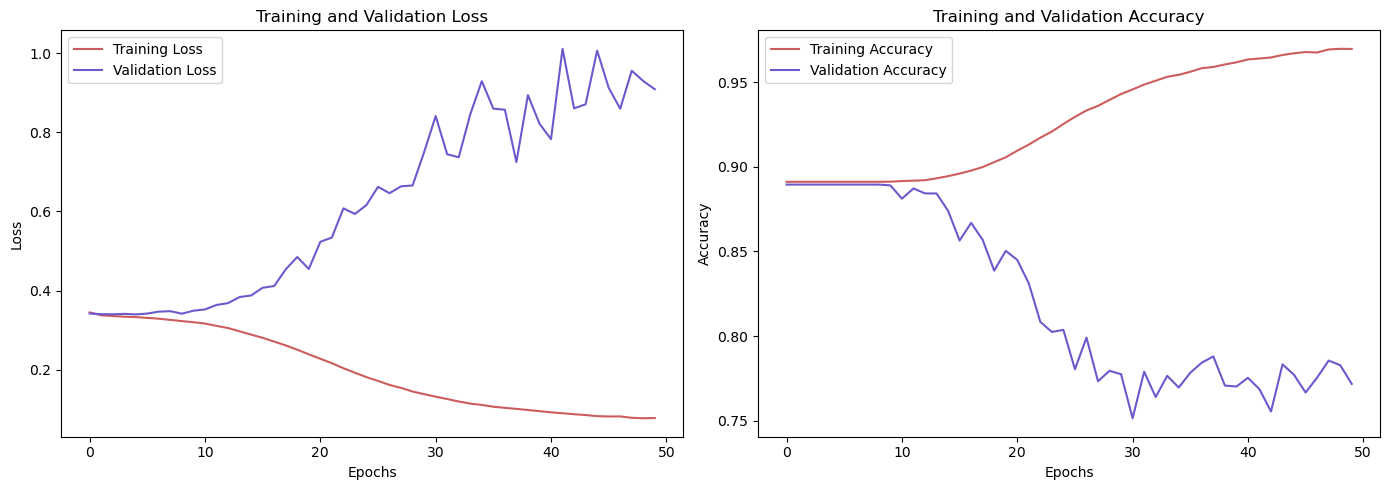

1189/1189 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step
Classification Report:

              precision    recall  f1-score   support

  Non-Sepsis       0.90      0.84      0.87     33817
      Sepsis       0.15      0.22      0.18      4202

    accuracy                           0.77     38019
   macro avg       0.52      0.53      0.52     38019
weighted avg       0.81      0.77      0.79     38019



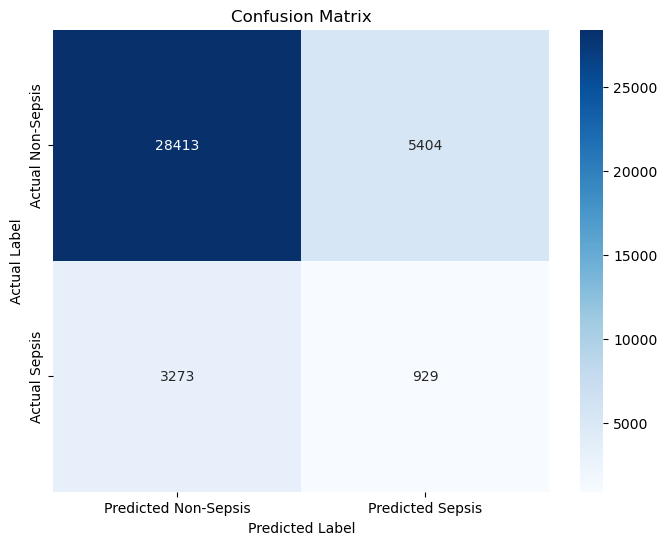

In [138]:
history_1 = history
model_1 = model
plot_training_history(history_1)
prediction_prob = evaluate_model_performance(model_1, padded_sequences_test_normalized, labels_test)

In [139]:
np.median(prediction_prob)

0.0010083508

1189/1189 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step
Classification Report:

              precision    recall  f1-score   support

  Non-Sepsis       0.91      0.54      0.68     33817
      Sepsis       0.14      0.58      0.22      4202

    accuracy                           0.54     38019
   macro avg       0.52      0.56      0.45     38019
weighted avg       0.83      0.54      0.63     38019



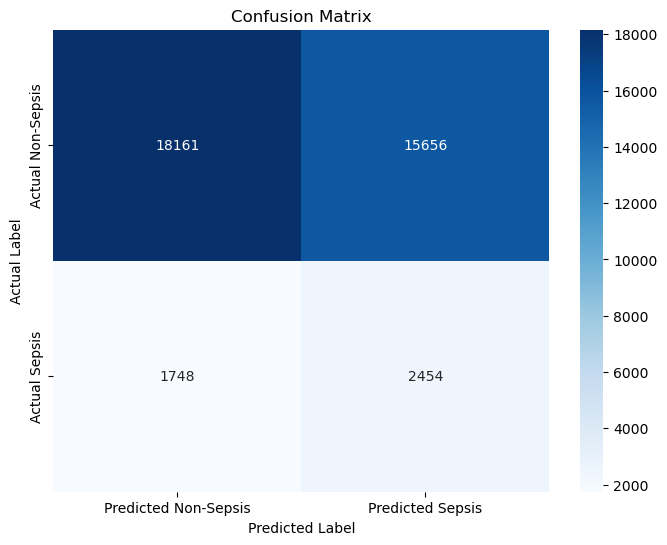

In [140]:
prediction_prob = evaluate_model_performance(model_1, padded_sequences_test_normalized, labels_test, 0.0015)

1189/1189 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step
Classification Report:

              precision    recall  f1-score   support

  Non-Sepsis       0.91      0.58      0.71     33817
      Sepsis       0.14      0.54      0.22      4202

    accuracy                           0.57     38019
   macro avg       0.52      0.56      0.46     38019
weighted avg       0.82      0.57      0.65     38019



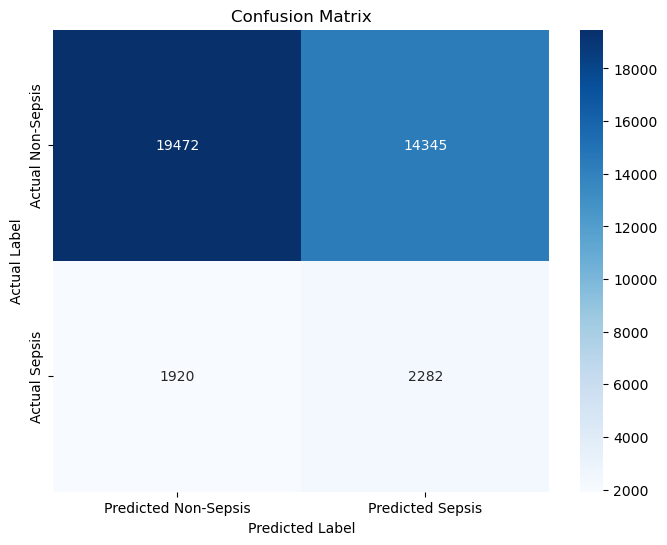

In [145]:
prediction_prob = evaluate_model_performance(model_1, padded_sequences_test_normalized, labels_test, 0.003)

# Modèle version 2

In [146]:
model, history = build_and_train_model_v2(padded_sequences_train_normalized, labels_train, padded_sequences_test_normalized, labels_test, input_shape)


C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.8905 - loss: 0.3514 - val_accuracy: 0.8895 - val_loss: 0.3408
Epoch 2/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 69s 14ms/step - accuracy: 0.8905 - loss: 0.3381 - val_accuracy: 0.8895 - val_loss: 0.3410
Epoch 3/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 70s 14ms/step - accuracy: 0.8910 - loss: 0.3352 - val_accuracy: 0.8895 - val_loss: 0.3398
Epoch 4/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 71s 15ms/step - accuracy: 0.8909 - loss: 0.3353 - val_accuracy: 0.8895 - val_loss: 0.3466
Epoch 5/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 66s 14ms/step - accuracy: 0.8910 - loss: 0.3328 - val_accuracy: 0.8895 - val_loss: 0.3411
Epoch 6/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 68s 14ms/step - accuracy: 0.8913 - loss: 0.3297 - val_accuracy: 0.8895 - val_loss: 0.3428
Epoch 7/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 69s 14ms/step - accuracy: 0.8894 - loss: 0.3322 - val_accuracy: 0.8895 - val_loss: 0.3418
Epoch 8/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 68s 14ms/step - accuracy: 0.8909 -


Validation Accuracy: 88.75%
Training Accuracy: 89.13%


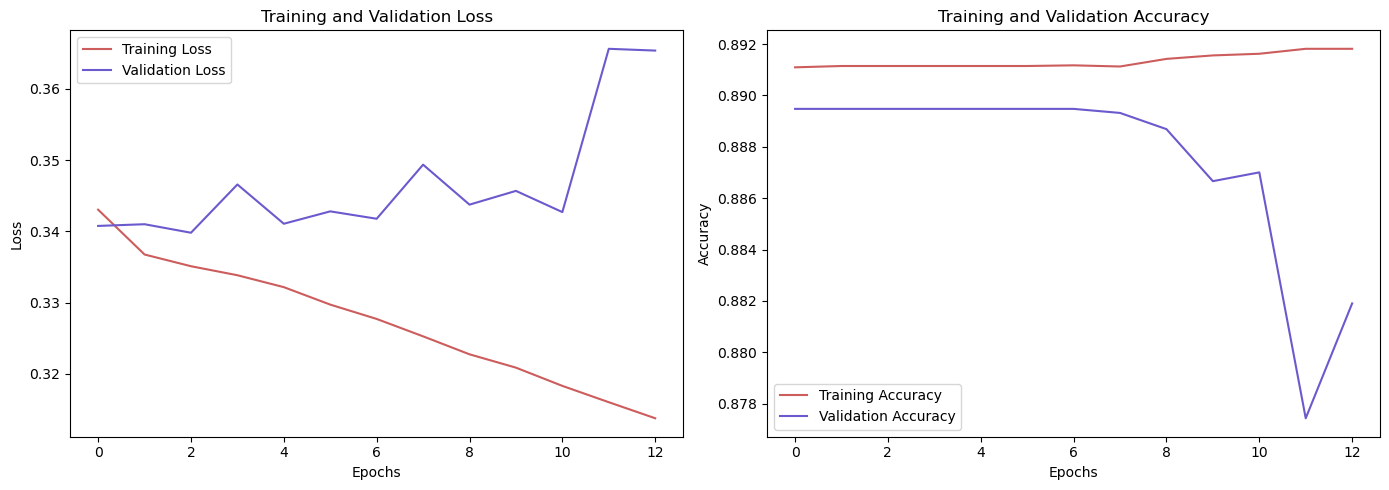

1189/1189 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
Classification Report:

              precision    recall  f1-score   support

  Non-Sepsis       0.89      1.00      0.94     33817
      Sepsis       0.00      0.00      0.00      4202

    accuracy                           0.89     38019
   macro avg       0.44      0.50      0.47     38019
weighted avg       0.79      0.89      0.84     38019



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


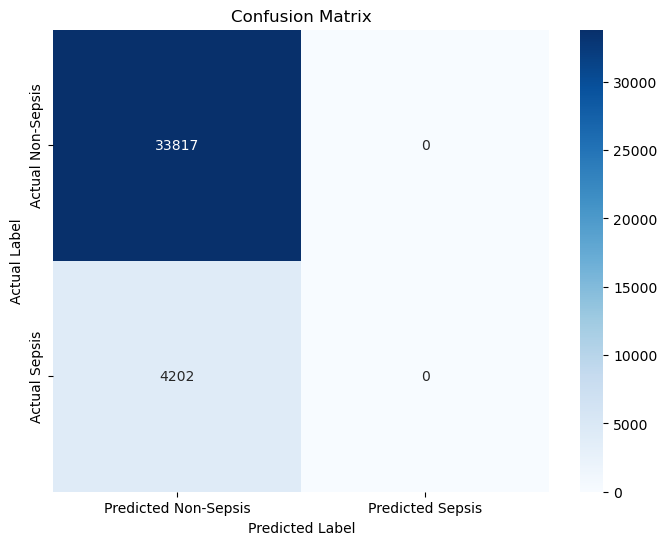

In [148]:
history_2 = history
model_2 = model
plot_training_history(history_2)
prediction_prob = evaluate_model_performance(model_2, padded_sequences_test_normalized, labels_test)

In [149]:
np.median(prediction_prob)

0.13304

1189/1189 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
Classification Report:

              precision    recall  f1-score   support

  Non-Sepsis       0.92      0.61      0.73     33817
      Sepsis       0.15      0.55      0.24      4202

    accuracy                           0.61     38019
   macro avg       0.53      0.58      0.48     38019
weighted avg       0.83      0.61      0.68     38019



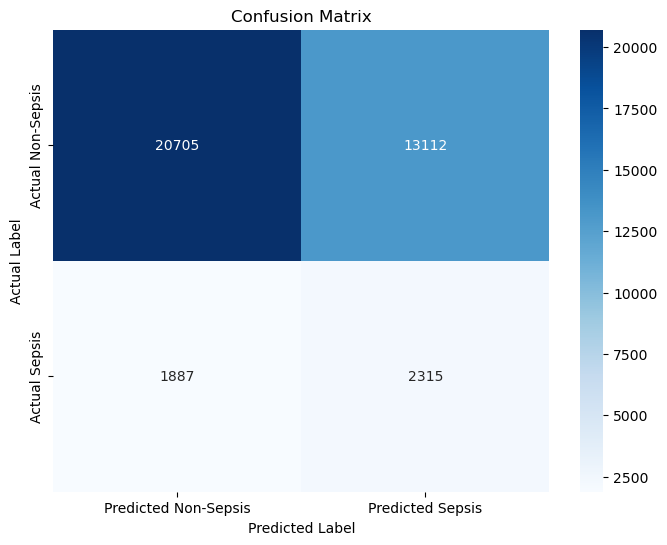

array([[0.03497319],
       [0.03844073],
       [0.04172228],
       ...,
       [0.13339263],
       [0.1322626 ],
       [0.13293089]], dtype=float32)

In [153]:
evaluate_model_performance(model_2, padded_sequences_test_normalized, labels_test, 0.138)

# Modèle version 3

In [154]:
model, history = build_and_train_model_v2(padded_sequences_train_normalized, labels_train, padded_sequences_test_normalized, labels_test, input_shape)

C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 133s 23ms/step - accuracy: 0.8907 - loss: 0.3566 - val_accuracy: 0.8895 - val_loss: 0.3418
Epoch 2/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 110s 23ms/step - accuracy: 0.8912 - loss: 0.3386 - val_accuracy: 0.8895 - val_loss: 0.3441
Epoch 3/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 115s 24ms/step - accuracy: 0.8915 - loss: 0.3355 - val_accuracy: 0.8895 - val_loss: 0.3400
Epoch 4/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 117s 24ms/step - accuracy: 0.8910 - loss: 0.3345 - val_accuracy: 0.8895 - val_loss: 0.3406
Epoch 5/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 116s 24ms/step - accuracy: 0.8905 - loss: 0.3352 - val_accuracy: 0.8895 - val_loss: 0.3400
Epoch 6/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 116s 24ms/step - accuracy: 0.8895 - loss: 0.3356 - val_accuracy: 0.8895 - val_loss: 0.3411
Epoch 7/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 117s 24ms/step - accuracy: 0.8905 - loss: 0.3318 - val_accuracy: 0.8895 - val_loss: 0.3405
Epoch 8/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 116s 24ms/step - accuracy: 

In [ ]:
history_3 = history
model_3 = model
plot_training_history(history_3)
prediction_prob = evaluate_model_performance(model_3, padded_sequences_test_normalized, labels_test)


Validation Accuracy: 88.80%
Training Accuracy: 89.16%


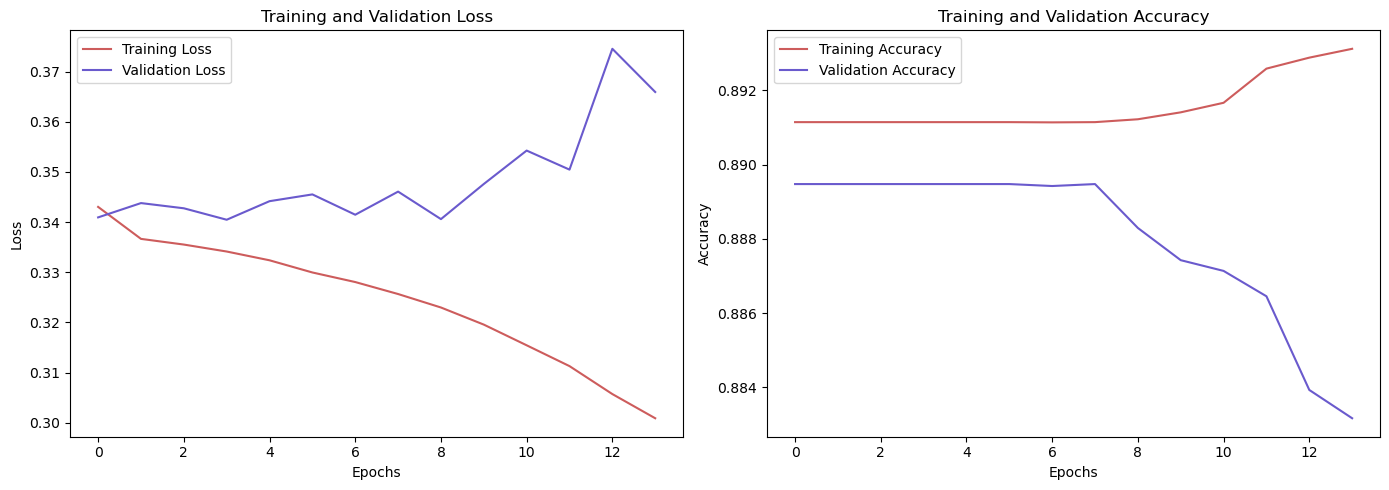

In [65]:
plot_training_history(history)


1189/1189 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
probabilités :  [[0.04820419]
 [0.0467062 ]
 [0.04627284]
 ...
 [0.11023598]
 [0.10748363]
 [0.10493833]]
Classification Report:

              precision    recall  f1-score   support

  Non-Sepsis       0.89      1.00      0.94     33817
      Sepsis       0.00      0.00      0.00      4202

    accuracy                           0.89     38019
   macro avg       0.44      0.50      0.47     38019
weighted avg       0.79      0.89      0.84     38019



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


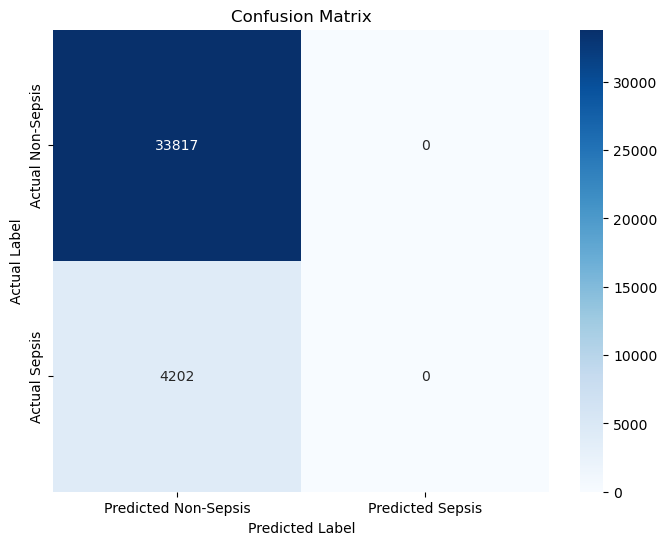

In [70]:
evaluate_model_performance(model, padded_sequences_test_normalized, labels_test)

# version 2

In [66]:
def build_and_train_model_v3(X_train, y_train, X_val, y_val, input_shape, epochs=50, batch_size=32):
    """
    Construit et entraîne un modèle LSTM pour la prédiction basée sur des données séquentielles.
    
    Args:
    X_train (np.array): Données d'entraînement.
    y_train (np.array): Étiquettes d'entraînement.
    X_val (np.array): Données de validation.
    y_val (np.array): Étiquettes de validation.
    input_shape (tuple): La forme des entrées (nombre de pas de temps, nombre de caractéristiques).
    epochs (int): Nombre maximum d'époques pour l'entraînement.
    batch_size (int): Taille du lot pour l'entraînement.
    
    Returns:
    keras.Model: Modèle entraîné.
    keras.callbacks.History: Historique de l'entraînement du modèle.
    """
    model = Sequential([
        LSTM(38, return_sequences=True, input_shape=input_shape),
        Dropout(0.25),
        LSTM(38, return_sequences=False),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])

    # Compilation du modèle
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Configuration de l'arrêt prématuré
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

    # Entraînement du modèle avec arrêt prématuré
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])

    return model, history


In [67]:
model, history = build_and_train_model_v3(padded_sequences_train_normalized, labels_train, padded_sequences_test_normalized, labels_test, input_shape)


Epoch 1/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - accuracy: 0.8890 - loss: 0.3538 - val_accuracy: 0.8895 - val_loss: 0.3408
Epoch 2/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - accuracy: 0.8901 - loss: 0.3389 - val_accuracy: 0.8895 - val_loss: 0.3420
Epoch 3/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 45s 9ms/step - accuracy: 0.8910 - loss: 0.3356 - val_accuracy: 0.8895 - val_loss: 0.3407
Epoch 4/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.8898 - loss: 0.3371 - val_accuracy: 0.8895 - val_loss: 0.3416
Epoch 5/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 50s 10ms/step - accuracy: 0.8914 - loss: 0.3314 - val_accuracy: 0.8895 - val_loss: 0.3400
Epoch 6/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 50s 10ms/step - accuracy: 0.8917 - loss: 0.3300 - val_accuracy: 0.8895 - val_loss: 0.3390
Epoch 7/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.8917 - loss: 0.3273 - val_accuracy: 0.8895 - val_loss: 0.3403
Epoch 8/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 50s 10ms/step - accuracy: 0.8913 - l


Validation Accuracy: 88.69%
Training Accuracy: 89.15%


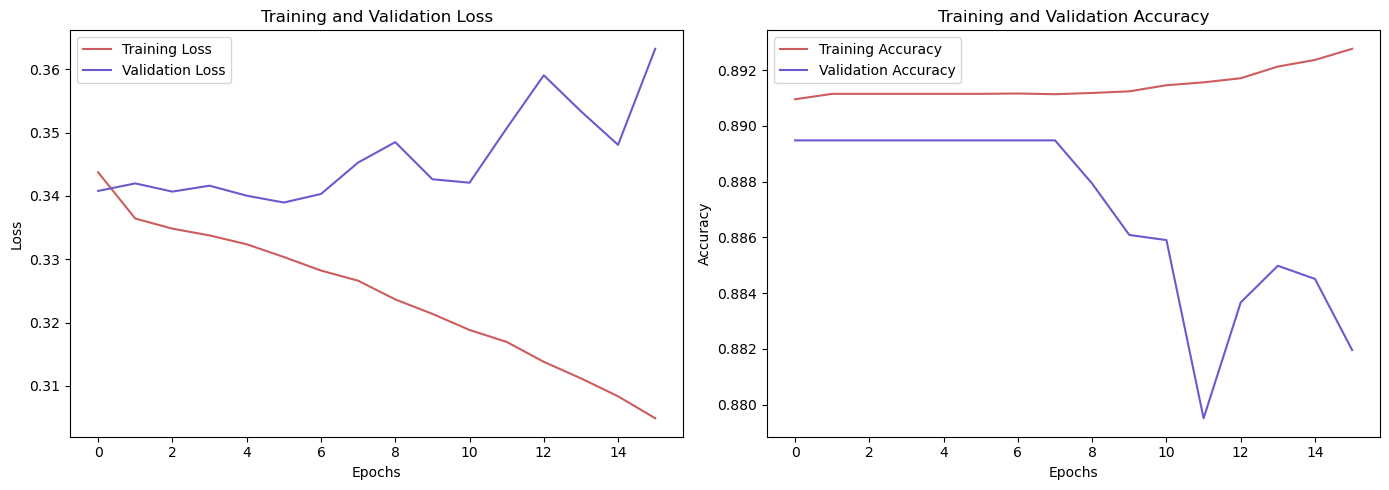

1189/1189 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Classification Report:

              precision    recall  f1-score   support

  Non-Sepsis       0.89      1.00      0.94     33817
      Sepsis       0.00      0.00      0.00      4202

    accuracy                           0.89     38019
   macro avg       0.44      0.50      0.47     38019
weighted avg       0.79      0.89      0.84     38019



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


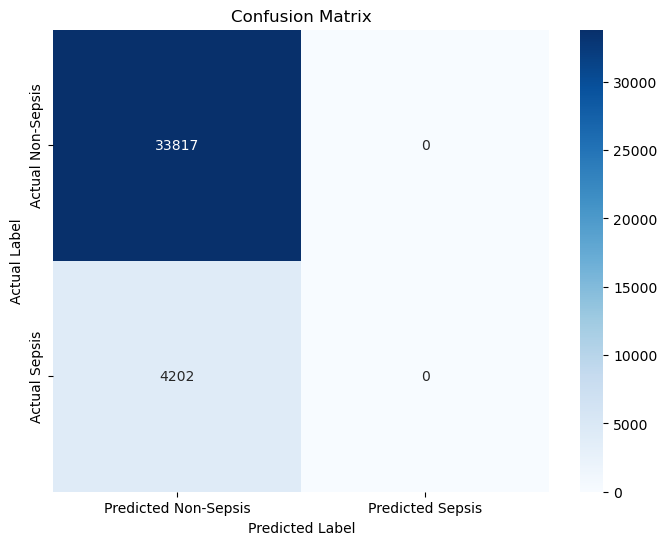

In [77]:
# Evolution de la précision et de la perte durant l'entrainement
plot_training_history(history) 

# autres mesures de performances, notamment la matrice de confusion
prediction_prob = evaluate_model_performance(model, padded_sequences_test_normalized, labels_test) 

In [85]:
(np.unique(prediction_prob).mean())

0.11196956

# version 4

In [86]:
def build_and_train_model_v4(X_train, y_train, X_val, y_val, input_shape, epochs=50, batch_size=32):
    """
    Construit et entraîne un modèle LSTM pour la prédiction basée sur des données séquentielles.
    
    Args:
    X_train (np.array): Données d'entraînement.
    y_train (np.array): Étiquettes d'entraînement.
    X_val (np.array): Données de validation.
    y_val (np.array): Étiquettes de validation.
    input_shape (tuple): La forme des entrées (nombre de pas de temps, nombre de caractéristiques).
    epochs (int): Nombre maximum d'époques pour l'entraînement.
    batch_size (int): Taille du lot pour l'entraînement.
    
    Returns:
    keras.Model: Modèle entraîné.
    keras.callbacks.History: Historique de l'entraînement du modèle.
    """
    model = Sequential([
        LSTM(38, return_sequences=True, input_shape=input_shape),
        Dropout(0.25),
        LSTM(228, return_sequences=False),
        Dropout(0.25),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])

    # Compilation du modèle
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Configuration de l'arrêt prématuré
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

    # Entraînement du modèle avec arrêt prématuré
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])

    return model, history


In [87]:
model, history = build_and_train_model_v4(padded_sequences_train_normalized, labels_train, padded_sequences_test_normalized, labels_test, input_shape)


C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 97s 19ms/step - accuracy: 0.8910 - loss: 0.3482 - val_accuracy: 0.8895 - val_loss: 0.3420
Epoch 2/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 91s 19ms/step - accuracy: 0.8922 - loss: 0.3348 - val_accuracy: 0.8895 - val_loss: 0.3395
Epoch 3/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 86s 18ms/step - accuracy: 0.8917 - loss: 0.3346 - val_accuracy: 0.8895 - val_loss: 0.3391
Epoch 4/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - accuracy: 0.8907 - loss: 0.3354 - val_accuracy: 0.8895 - val_loss: 0.3386
Epoch 5/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 88s 18ms/step - accuracy: 0.8911 - loss: 0.3336 - val_accuracy: 0.8895 - val_loss: 0.3397
Epoch 6/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 86s 18ms/step - accuracy: 0.8916 - loss: 0.3304 - val_accuracy: 0.8895 - val_loss: 0.3381
Epoch 7/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 85s 17ms/step - accuracy: 0.8923 - loss: 0.3278 - val_accuracy: 0.8895 - val_loss: 0.3419
Epoch 8/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 83s 17ms/step - accuracy: 0.8917 -


Validation Accuracy: 88.74%
Training Accuracy: 89.14%


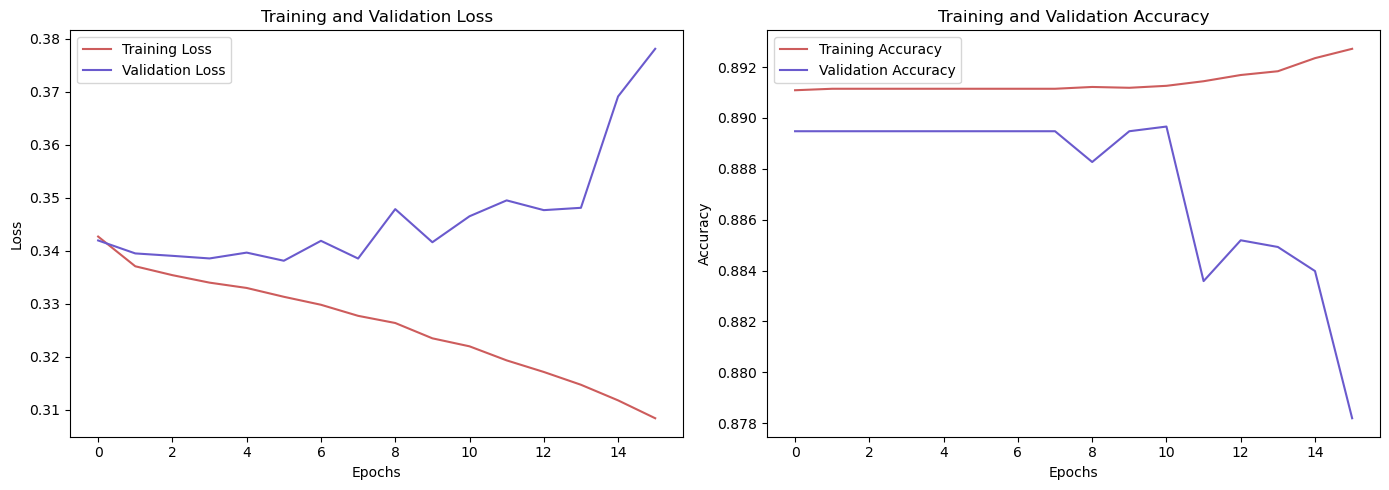

1189/1189 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
Classification Report:

              precision    recall  f1-score   support

  Non-Sepsis       0.89      1.00      0.94     33817
      Sepsis       0.00      0.00      0.00      4202

    accuracy                           0.89     38019
   macro avg       0.44      0.50      0.47     38019
weighted avg       0.79      0.89      0.84     38019



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


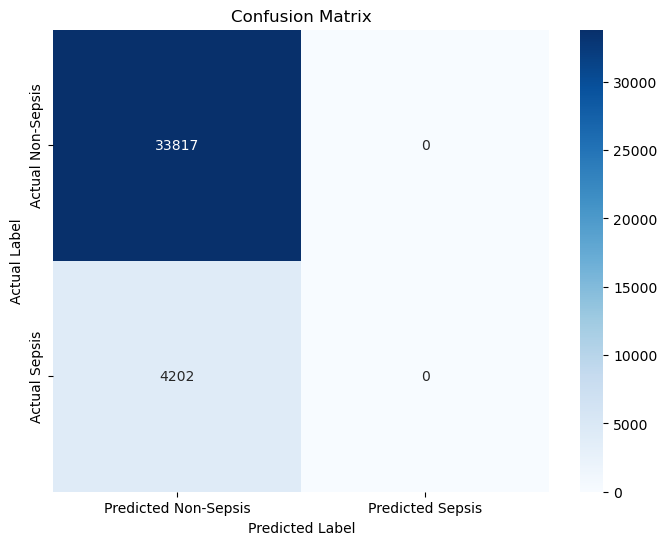

In [88]:
# Evolution de la précision et de la perte durant l'entrainement
plot_training_history(history) 

# autres mesures de performances, notamment la matrice de confusion
prediction_prob = evaluate_model_performance(model, padded_sequences_test_normalized, labels_test) 

In [89]:
np.unique(prediction_prob).mean()

0.11851312

1189/1189 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
Classification Report:

              precision    recall  f1-score   support

  Non-Sepsis       0.86      0.56      0.68     33817
      Sepsis       0.07      0.25      0.10      4202

    accuracy                           0.53     38019
   macro avg       0.46      0.41      0.39     38019
weighted avg       0.77      0.53      0.62     38019



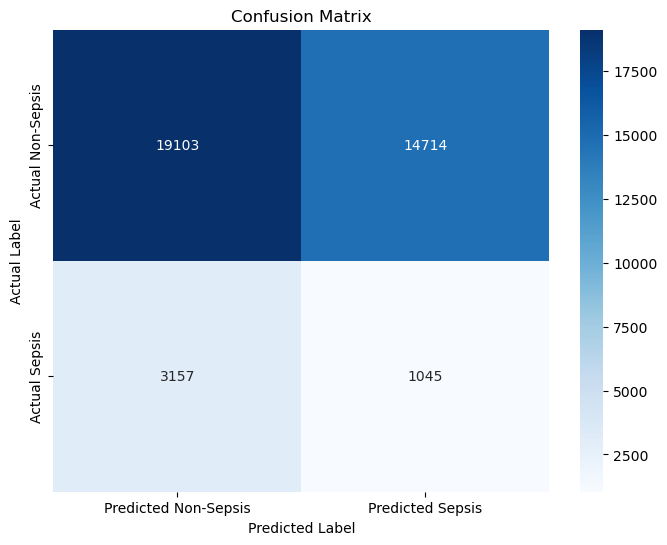

In [110]:
prediction_prob = evaluate_model_performance(model, padded_sequences_test_normalized, labels_test, 0.112) 

1189/1189 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
Classification Report:

              precision    recall  f1-score   support

  Non-Sepsis       0.93      0.46      0.61     33817
      Sepsis       0.14      0.73      0.24      4202

    accuracy                           0.49     38019
   macro avg       0.54      0.59      0.43     38019
weighted avg       0.84      0.49      0.57     38019



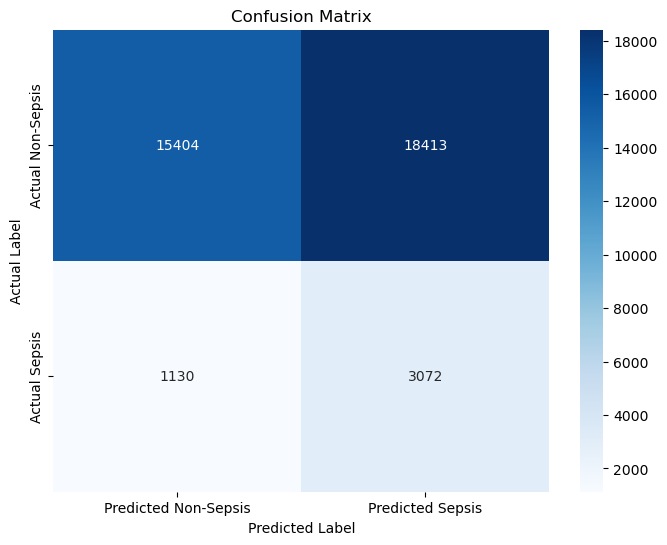

In [95]:
prediction_prob = evaluate_model_performance(model, padded_sequences_test_normalized, labels_test, 0.115) 

In [111]:
# Deuxième modèle qui apprend sur les probabilités
def build_and_train_adjustment_model(X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    model = Sequential([
        Dense(10, activation='relu', input_dim=1),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])

    return model, history



In [112]:
# Prédiction des probabilités sur l'ensemble de validation
probas_val = model.predict(padded_sequences_test_normalized)

# Prédiction des probabilités sur l'ensemble d'entraînement (pour entraîner le second modèle)
probas_train = model.predict(padded_sequences_train_normalized)


1189/1189 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step


In [113]:
# Notez que probas_train et probas_val doivent être redimensionnés pour correspondre à l'input du modèle
model_adjustment, history_adjustment = build_and_train_adjustment_model(probas_train, labels_train, probas_val, labels_test)



Epoch 1/50


C:\Users\AdminPC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4854/4854 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8884 - loss: 0.4079 - val_accuracy: 0.8895 - val_loss: 0.3469
Epoch 2/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8915 - loss: 0.3412 - val_accuracy: 0.8895 - val_loss: 0.3422
Epoch 3/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8914 - loss: 0.3350 - val_accuracy: 0.8895 - val_loss: 0.3386
Epoch 4/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8923 - loss: 0.3279 - val_accuracy: 0.8895 - val_loss: 0.3379
Epoch 5/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8913 - loss: 0.3273 - val_accuracy: 0.8895 - val_loss: 0.3386
Epoch 6/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8916 - loss: 0.3263 - val_accuracy: 0.8895 - val_loss: 0.3391
Epoch 7/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8903 - loss: 0.3285 - val_accuracy: 0.8895 - val_loss: 0.3393
Epoch 8/50
4854/4854 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8901 - loss: 0.3298 - val_acc

1189/1189 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Classification Report:

              precision    recall  f1-score   support

  Non-Sepsis       0.90      0.92      0.91     33817
      Sepsis       0.17      0.13      0.15      4202

    accuracy                           0.83     38019
   macro avg       0.53      0.53      0.53     38019
weighted avg       0.82      0.83      0.82     38019



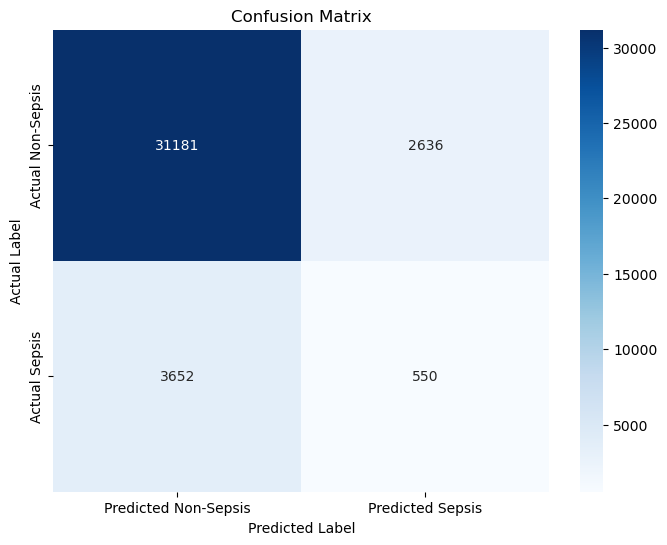

In [133]:
prediction_prob = evaluate_model_performance(model_adjustment, probas_val, labels_test, 0.17) 

In [124]:
np.max(prediction_prob)

0.25391665

In [37]:
padded_sequences_train_normalized.shape

(155318, 6, 38)

In [39]:
np.array(labels_train).shape

(155318,)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_and_train_model(X_train, y_train, sequence_length, epochs=10, batch_size=64, learning_rate=0.001):
    """
    Construit, compile et entraîne un modèle LSTM.

    Parameters:
    X_train (numpy.array): Les données d'entraînement.
    y_train (numpy.array): Les étiquettes d'entraînement.
    sequence_length (int): La longueur des séquences d'entrée.
    epochs (int): Nombre d'époques d'entraînement. Par défaut 10.
    batch_size (int): Taille des lots pour l'entraînement. Par défaut 64.
    learning_rate (float): Taux d'apprentissage. Par défaut 0.001.

    Returns:
    model: Le modèle LSTM entraîné.
    history: L'historique d'entraînement du modèle.
    """

    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    return model, history


In [ ]:
# Exemple d'utilisation de la fonction
model, history = build_and_train_model(X_train, y_train, sequence_length, epochs=20, batch_size=64, learning_rate=0.001)


In [ ]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy is', val_accuracy*100))

history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#CD5C5C", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#FF0000", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#CD5C5C", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']],"#FF0000", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model_performance(model, X_test, y_test, threshold=0.5):
    """
    Évalue les performances d'un modèle sur l'ensemble de test et affiche les métriques de performance.

    Parameters:
    model: Le modèle entraîné à évaluer.
    X_test (numpy.array): Les données de test.
    y_test (numpy.array): Les étiquettes de test.
    threshold (float): Le seuil pour la prédiction binaire. Par défaut 0.5.

    Returns:
    metrics: Un dictionnaire contenant les métriques de performance.
    """
    # Prédictions sur l'ensemble de test
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > threshold).astype(int)

    # Calcul des métriques
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Affichage des métriques
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

    # Affichage de la matrice de confusion et du rapport de classification
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print('Confusion Matrix:')
    print(conf_matrix)
    print('\nClassification Report:')
    print(class_report)
    
    # Renvoyer les métriques sous forme de dictionnaire
    metrics = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }
    return metrics


In [ ]:
# Exemple d'utilisation de la fonction
metrics = evaluate_model_performance(model, X_test, y_test, threshold=0.5)